In [242]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_t as mvt
from utils import * 
from tqdm import tqdm
from matplotlib.cm import get_cmap
from matplotlib.collections import LineCollection
from scipy.interpolate import interp1d

In [243]:

def plot_particle(states, state_estimates, measurements, particle_history, line_segments):
    min_x, max_x = np.inf, -np.inf
    min_y, max_y = np.inf, -np.inf
    
    for line_segment in line_segments:
        min_x = np.min([min_x, np.min(line_segment[:, 0])])
        max_x = np.max([max_x, np.max(line_segment[:, 0])])
        min_y = np.min([min_y, np.min(line_segment[:, 1])])
        max_y = np.max([max_y, np.max(line_segment[:, 1])])

    min_x = np.min([min_x, np.min(states[:, 0]), np.min(measurements[:, 0])])
    max_x = np.max([max_x, np.max(states[:, 0]), np.max(measurements[:, 0])])
    min_y = np.min([min_y, np.min(states[:, 1]), np.min(measurements[:, 1])])
    max_y = np.max([max_y, np.max(states[:, 1]), np.max(measurements[:, 1])])
    
    
    n = len(states)
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))

    # Plot particle history
    blues = get_cmap('Blues')(np.linspace(0.2, 1.0, n))
    for k in range(n):
        ax.scatter(particle_history[k, :, 0], particle_history[k, :, 1], s=1, color=blues[k])

    points = state_estimates[:, :2]
    points = interp1d(np.arange(n), points, axis=0)(np.linspace(0, n - 1, 10000))
    points = points.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    #lc1 = LineCollection(segments, colors=greys, linewidths=3, edgecolors='k', linestyle='--')
    lc1_color = get_cmap('Greys')(np.linspace(0.5, 1, len(segments)))[::-1]
    lc1 = LineCollection(segments, colors=lc1_color, linewidths=4, linestyles='solid')

    lc2_color = get_cmap('Blues')(np.linspace(0.2, 1, len(segments)))[::-1]
    lc2 = LineCollection(segments, colors=lc2_color, linewidths=1.5, linestyles='solid', label='Estimated')

    ax.add_collection(lc1)
    ax.add_collection(lc2)

    greys = get_cmap('Greys')(np.linspace(0.5, 1, n))[::-1]
    ax.scatter(measurements[:, 0], measurements[:, 1], s=15, c=greys, marker='^')

    blues = get_cmap('Blues')(np.linspace(0.2, 1, n))[::-1]
    ax.scatter(measurements[:, 0], measurements[:, 1], s=7.5, c=blues, marker='^')
    
    ax.plot(states[:, 0], states[:, 1], color='k', linewidth=2, linestyle='solid', label='True')

    for line_segment in line_segments:
        ax.plot(line_segment[:, 0], line_segment[:, 1], color='k', linewidth=2, linestyle='solid')

    ax.set_xlim(min_x - 3, max_x + 3)
    ax.set_ylim(min_y - 3, max_y + 3)
    ax.set_aspect('equal')
    
    # Caluclate and show MSE
    mse = np.mean(np.linalg.norm(states[:, :2] - state_estimates[:, :2], axis=1))
    ax.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')

    #ax.legend()

    plt.show()

In [244]:
def line_search(m, h, c):
    start = m
    end = h

    while np.linalg.norm(start - end) > 1e-6:
        mid = (start + end) / 2
        if c(mid):
            start = mid
        else:
            end = mid

    return end

def nearest_point(x0, y0, c, precision=0.01, max_dist=1000):
    radius = 0

    while radius < max_dist:
        for theta in np.linspace(0, 2 * math.pi, 100):
            x = x0 + radius * np.cos(theta)
            y = y0 + radius * np.sin(theta)
            if c([x, y, 0, 0]):
                # Get the unit vector from (x, y) to (x0, y0)
                unit_vector = np.array([x0 - x, y0 - y]) / np.linalg.norm(np.array([x0 - x, y0 - y]))
                x_tmp = x + unit_vector[0] * precision
                y_tmp = y + unit_vector[1] * precision                
                
                return line_search(np.array([x_tmp, y_tmp, 0, 0]), np.array([x, y, 0, 0]), c)[:2]
                
        radius += precision

In [245]:
class PF_CONSTRAINED:
    def __init__(self, f, h, Q, R, c, dim_m = 4, dim_y = 2, N=500, resample_criterion = False,
                 resampling_method = 'systematic', constrained_method = 'line', distribution = 'normal'):
        self.f = f
        self.h = h
        self.Q = Q
        self.R = R
        self.dim_m = dim_m
        self.dim_y = dim_y
        self.N = N
        self.resample_criterion = resample_criterion
        self.c = c
        
        self.resampling_method = resampling_method
        self.constrained_method = constrained_method
        
        if distribution == 'normal':
            self.q = lambda mean, cov: mvn(mean, cov)
        elif distribution == 't':
            self.q = lambda mean, cov: mvt(mean, cov, df=5)
        else:
            raise ValueError('Unknown distribution')
        
        
        if self.constrained_method == 'line':
            update = self.update_line_search
        elif self.constrained_method == 'line2':
            update = self.update_line_search2
        elif self.constrained_method == 'nearest':
            update = self.update_nearest_point
        elif self.constrained_method == 'accept_reject':
            update = self.update_accept_reject
        elif self.constrained_method == 'none':
            update = self.update
        else:
            raise ValueError('Unknown constrained method')
        
        assert dim_m == len(Q)
        assert dim_y == len(R)
        
        
    def resample(self, particles, weights):
        if not self.resample_criterion or 1. / np.sum(np.square(weights)) < self.N / 2:
            if self.resampling_method == 'systematic':
                indexes = systematic_resampling(weights)
            elif self.resampling_method == 'residual':
                indexes = residual_resampling(weights)
            elif self.resampling_method == 'stratified':
                indexes = stratified_resampling(weights)
            else:
                raise ValueError('Unknown resampling method')
            
            return particles[indexes], np.ones(self.N) / self.N
        else:
            return particles, weights
        
    def predict(self, particles, weights):
        for i, particle in enumerate(particles):
            particles[i] = self.q(self.f(particle), self.Q).rvs()
            
        return particles, weights
    
    def update(self, y, particles, weights, last_m):
        for i, (weight, particle) in enumerate(zip(weights, particles)):
            weights[i] *= mvn(self.h(particle), self.R).pdf(y)

        weights /= np.sum(weights)

        return particles, weights
    
    def update_line_search(self, y, particles, weights, last_m):
        
        m = np.average(particles, weights=weights, axis=0)
        
        if self.c(m):
            for i, particle in enumerate(particles):
                if self.c(particle):
                    particles[i] = particle
                    weights[i] *= self.q(self.h(particles[i]), self.R).pdf(y)
                else:
                    particles[i] = line_search(m, particle, self.c)
                    weights[i] *= self.q(self.h(particles[i]), self.R).pdf(y)
          
        else:
            for i, particle in enumerate(particles):
                particles[i] = line_search(last_m, particle, self.c)
                weights[i] *= self.q(self.h(particles[i]), self.R).pdf(y)
                
        
    def update_line_search_2(self, y, particles, weights, last_m):
        m = np.average(particles, weights=weights, axis=0)
        
        if self.c(m):
            for i, particle in enumerate(particles):
                if self.c(particle):
                    particles[i] = particle
                    weights[i] *= self.q(self.h(particles[i]), self.R).pdf(y)
                else:
                    particles[i] = line_search(m, particle, self.c)
                    weights[i] *= self.q(self.h(particles[i]), self.R).pdf(y)
        else:
            for i, particle in enumerate(particles):
                particles[i] = line_search(last_m, particle, self.c)
                weights[i] *= self.q(self.h(particles[i]), self.R).pdf(y)      
                
        weights /= np.sum(weights)
        
        return particles, weights         
    
    def update_line_search_nearest(self, y, particles, weights, last_m):
        m = np.average(particles, weights=weights, axis=0)
        
        if self.c(m):
            for i, particle in enumerate(particles):
                if self.c(particle):
                    particles[i] = particle
                    weights[i] *= self.q(self.h(particles[i]), self.R).pdf(y)
                else:
                    particles[i] = line_search(m, particle, self.c)
                    weights[i] *= self.q(self.h(particles[i]), self.R).pdf(y)
        
        else:
            x, y = nearest_point(m[0], m[1], self.c)
            m_tmp = m.copy()
            m_tmp[:2] = x, y
            
            for i, particle in enumerate(particles):
                if self.c(particle):
                    particles[i] = particle
                    weights[i] *= self.q(self.h(particles[i]), self.R).pdf(y)
                else:
                    particles[i] = line_search(m_tmp, particle, self.c)
                    weights[i] *= self.q(self.h(particles[i]), self.R).pdf(y)
            
        weights /= np.sum(weights)
        
        return particles, weights
    
    def update_accept_reject(self, y, particles, weights, m):
        for i, particle in enumerate(particles):
            if self.c(particle):
                weights[i] *= self.q(self.h(particle), self.R).pdf(y)
            else:
                weights[i] *= 0
                
        weights /= np.sum(weights)
        
        return particles, weights
    
    def filter(self, measurements, m = None, P = None, verbose = True):
        if m is None: m = np.zeros(self.dim_m)
        if P is None: P = np.eye(self.dim_m)
        
        n = len(measurements)
        state_estimates = np.empty((n, self.dim_m))
        cov_estimates = np.empty((n, self.dim_m, self.dim_m))
        particle_history = np.empty((n, self.N, self.dim_m))
        resampled_history = np.empty((n, self.N, self.dim_m))
        weights_history = np.empty((n, self.N))

        # Draw N samples from the prior
        particles = self.q(m, P).rvs(self.N)
        weights = np.ones(self.N) / self.N
        
        if verbose:
            iterator = tqdm(enumerate(measurements), total=n)
        else:
            iterator = enumerate(measurements)            
        
        for k, y in iterator:
            particles, weights = self.predict(particles, weights)
            particles, weights = self.update(y, particles, weights, m)            
            
            m = np.average(particles, weights=weights, axis=0)            
            P = np.sum([weights[i] * np.outer(particles[i] - m, particles[i] - m)
                        for i in range(self.N)], axis=0)
            
            state_estimates[k] = m
            cov_estimates[k] = P
            particle_history[k] = particles
            weights_history[k] = weights
            
            particles, weights = self.resample(particles, weights)
            resampled_history[k] = particles
            
        return state_estimates, cov_estimates, particle_history, weights_history, resampled_history
    
    # Particle Rauch-Tung-Striebel (URTS) Smoother
    def smoother(self, state_estimates, cov_estimates, particle_history, weights_history, verbose = True):
        n = len(state_estimates)
        state_estimates_smoothed = np.empty((n, self.dim_m))
        state_estimates_smoothed[-1] = state_estimates[-1]
        cov_estimates_smoothed = np.empty((n, self.dim_m, self.dim_m))
        cov_estimates_smoothed[-1] = cov_estimates[-1]
        
        if verbose:
            iterator = tqdm(range(n - 2, -1, -1), initial=1, total=n)
        else:
            iterator = range(n - 2, -1, -1)

        for k in iterator:
            m = state_estimates[k]
            P = cov_estimates[k]
            
            weights = weights_history[k]
            particles = particle_history[k]

            particles_transformed = np.empty_like(particles)
            for i, particle in enumerate(particles):
                particles_transformed[i] = self.f(particle)
            
            m_pred = np.average(particles_transformed, weights=weights, axis=0)
            P_pred = np.sum([weights[i] * np.outer(particles_transformed[i] - m_pred, particles_transformed[i] - m_pred)
                             for i in range(self.N)], axis=0) + self.Q
            
            D = np.sum([weights[i] * np.outer(particles[i] - m, particles_transformed[i] - m_pred)
                        for i in range(self.N)], axis=0)
            G = D @ np.linalg.inv(P_pred)
            
            state_estimates_smoothed[k] = m + G @ (state_estimates_smoothed[k + 1] - m_pred)
            cov_estimates_smoothed[k] = P + G @ (cov_estimates_smoothed[k + 1] - P_pred) @ G.T
            
        return state_estimates_smoothed, cov_estimates_smoothed

In [246]:
x_points, y_points, line_segments = track_example1()
trajectory = MPCTrajectory(x_points, y_points, line_segments, savepath='output/track_1.pkl')
states, measurements = trajectory.get_data()
states = states[::2]
measurements = measurements[::2]
n = len(states)
#states[:, 2:] *= 10

In [247]:
q1 = 1
q2 = 1
dt = 0.2

A = np.array([[1, 0, dt, 0],
             [0, 1, 0, dt],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])

f = lambda x: A @ x
h = lambda x: trajectory.h(x)

Q = np.array([[(q1 * dt**3) / 3, 0, (q1 * dt**2) / 2, 0],
              [ 0, (q2 * dt**3) / 3, 0, (q2 * dt**2) / 2],
              [(q1 * dt**2) / 2, 0, q1 * dt, 0],
              [0, (q2 * dt**2) / 2, 0, q2 * dt]])

R = trajectory.R

In [248]:
#particle_filter = PF_CONSTRAINED(f, h, Q, R, dim_m = 4, dim_y = 2)
particle_filter = PF(f, h, Q, R, dim_m = 4, dim_y = 2)
state_estimates_uncon, cov_estimates_uncon, particle_history_uncon, weights_history_uncon = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed_uncon, cov_estimates_smoothed_uncon = particle_filter.smoother(state_estimates_uncon, cov_estimates_uncon, particle_history_uncon, weights_history_uncon, verbose=True)

  0%|          | 0/171 [00:00<?, ?it/s]

  1%|          | 1/171 [00:00<?, ?it/s]

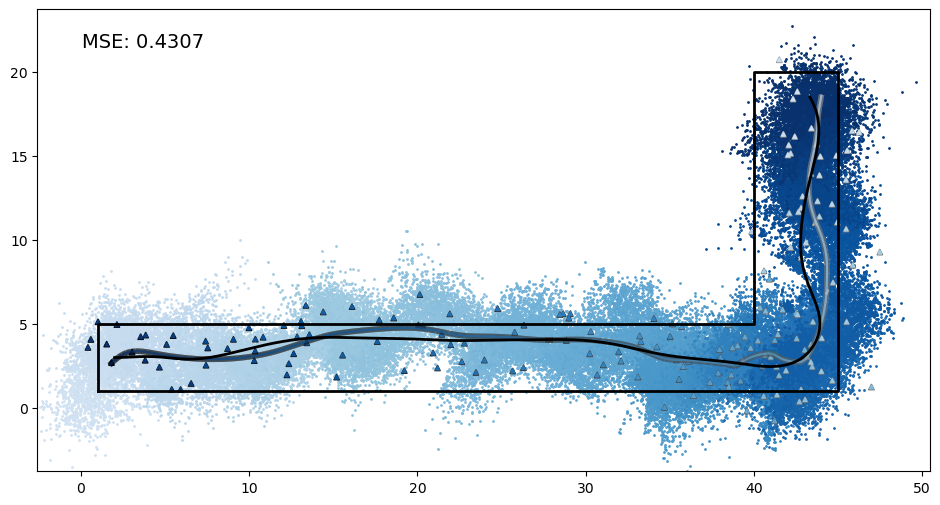

In [249]:
plot_particle(states, state_estimates_smoothed_uncon, measurements, particle_history_uncon, line_segments)

In [250]:
c = make_point_in_polygon(line_segments[0])
particle_filter = PF_CONSTRAINED(f, h, Q, R, c, dim_m = 4, dim_y = 2, constrained_method='accept_reject', distribution='normal')
state_estimates_con, cov_estimates_con, particle_history_con, weights_history_con, resampled_history_con = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed_con, cov_estimates_smoothed_con = particle_filter.smoother(state_estimates_con, cov_estimates_con, particle_history_con, weights_history_con, verbose=True)

100%|██████████| 171/171 [00:01<00:00, 146.07it/s]


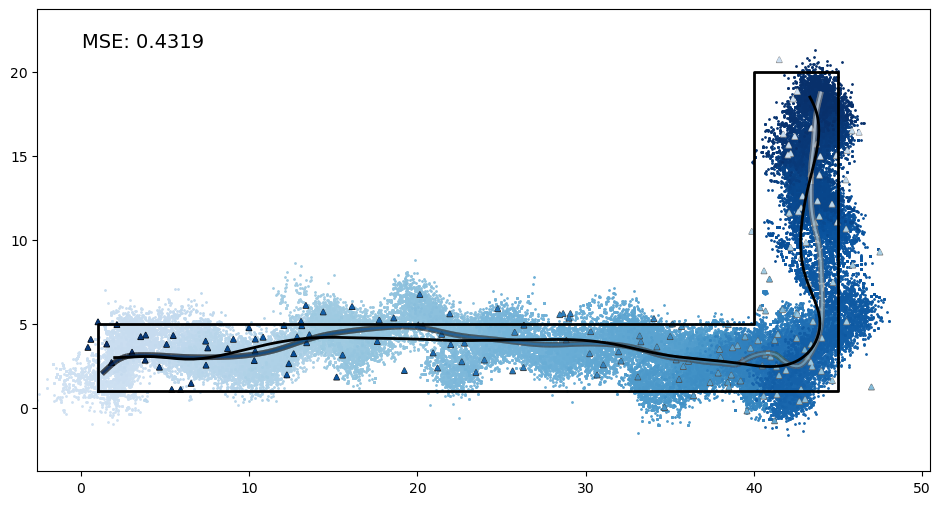

In [251]:
plot_particle(states, state_estimates_smoothed_con, measurements, resampled_history_con, line_segments)

In [252]:
particle_filter_2 = PF_CONSTRAINED(f, h, Q, R, c, dim_m = 4, dim_y = 2, constrained_method='line', distribution='normal')
state_estimates_con_2, cov_estimates_con_2, particle_history_con_2, weights_history_con_2, resampled_history_con_2 = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed_con_2, cov_estimates_smoothed_con_2 = particle_filter.smoother(state_estimates_con_2, cov_estimates_con_2, particle_history_con_2, weights_history_con_2, verbose=True)

100%|██████████| 171/171 [00:01<00:00, 106.18it/s]


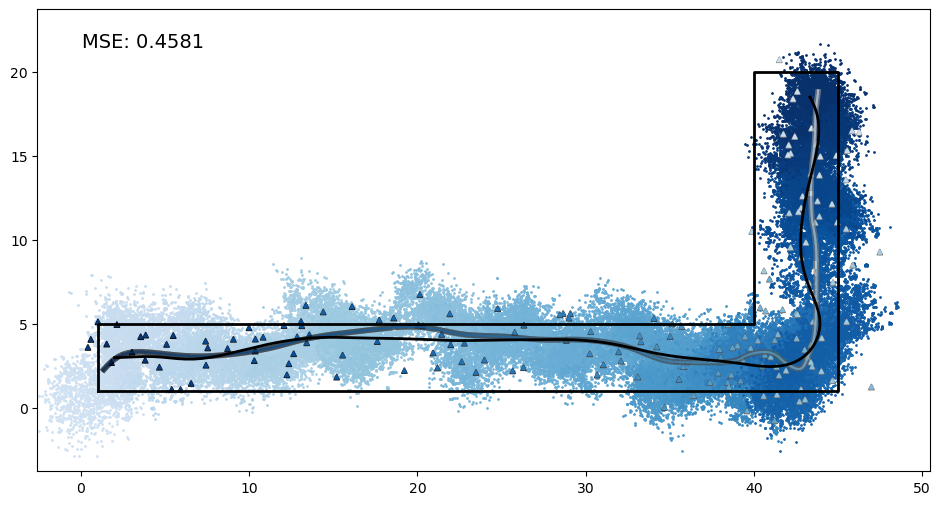

In [254]:
plot_particle(states, state_estimates_smoothed_con_2, measurements, particle_history_con_2, line_segments)

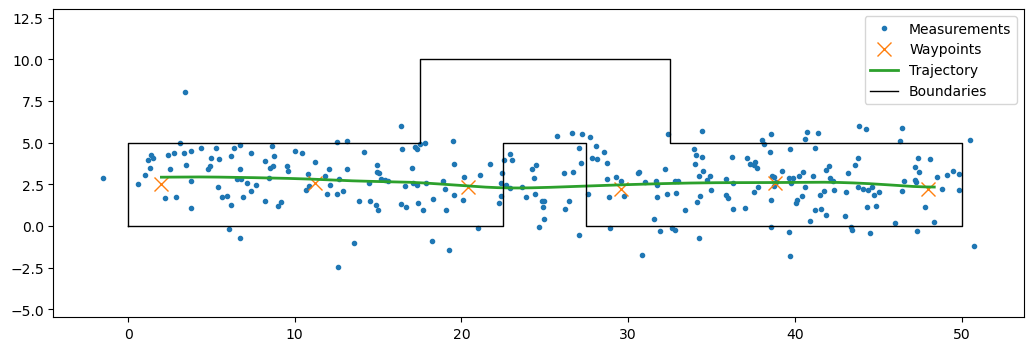

In [255]:
x_coords, y_coords, line_segments = track_example3()
trajectory = MPCTrajectory(x_coords, y_coords, line_segments, savepath='output/track_3.pkl')
states, measurements = trajectory.get_data()
trajectory.plot()
states = states[::2]
measurements = measurements[::2]

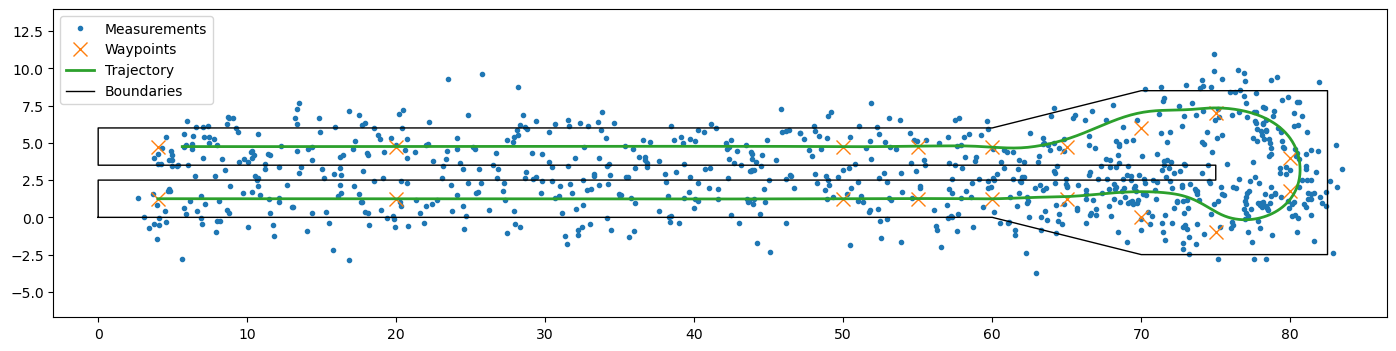

In [256]:
x_coords, y_coords, line_segments = track_example2()
trajectory = MPCTrajectory(x_coords, y_coords, line_segments, savepath='output/track_2.pkl')
states, measurements = trajectory.get_data()
trajectory.plot()

In [257]:
c = make_constrint(line_segments[0])
#particle_filter_3 = PF_CONSTRAINED(f, h, Q, R, c, dim_m = 4, dim_y = 2, constrained_method='none', distribution='normal', N = 500)
particle_filter_3 = PF(f, h, Q, R, dim_m = 4, dim_y = 2)
state_estimates_con_3, cov_estimates_con_3, particle_history_con_3, weights_history_con_3, resampled_history_con_3 = particle_filter.filter(measurements, verbose=True)
state_estimates_smoothed_con_3, cov_estimates_smoothed_con_3 = particle_filter.smoother(state_estimates_con_3, cov_estimates_con_3, particle_history_con_3, weights_history_con_3, verbose=True)

100%|██████████| 864/864 [00:08<00:00, 101.26it/s]


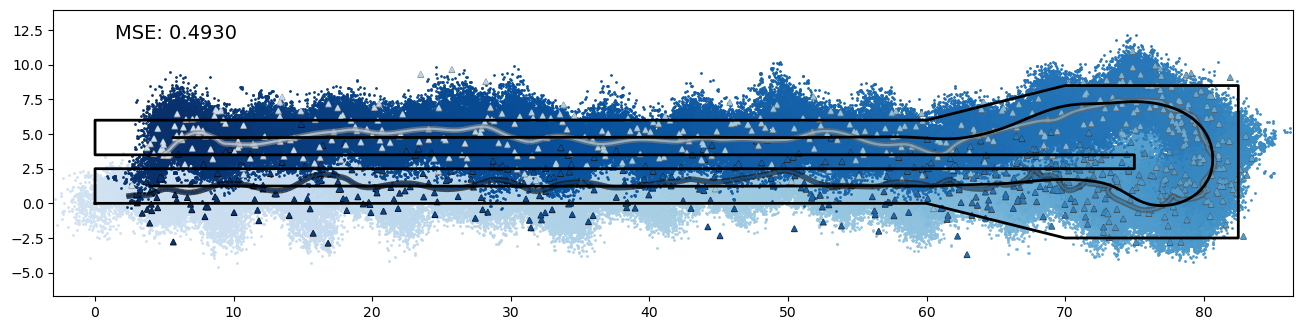

In [261]:
plot_particle(states, state_estimates_smoothed_con_3, measurements, particle_history_con_3, line_segments)